## Forecasting and Analyzing Baseball
#### Double Play Analytics

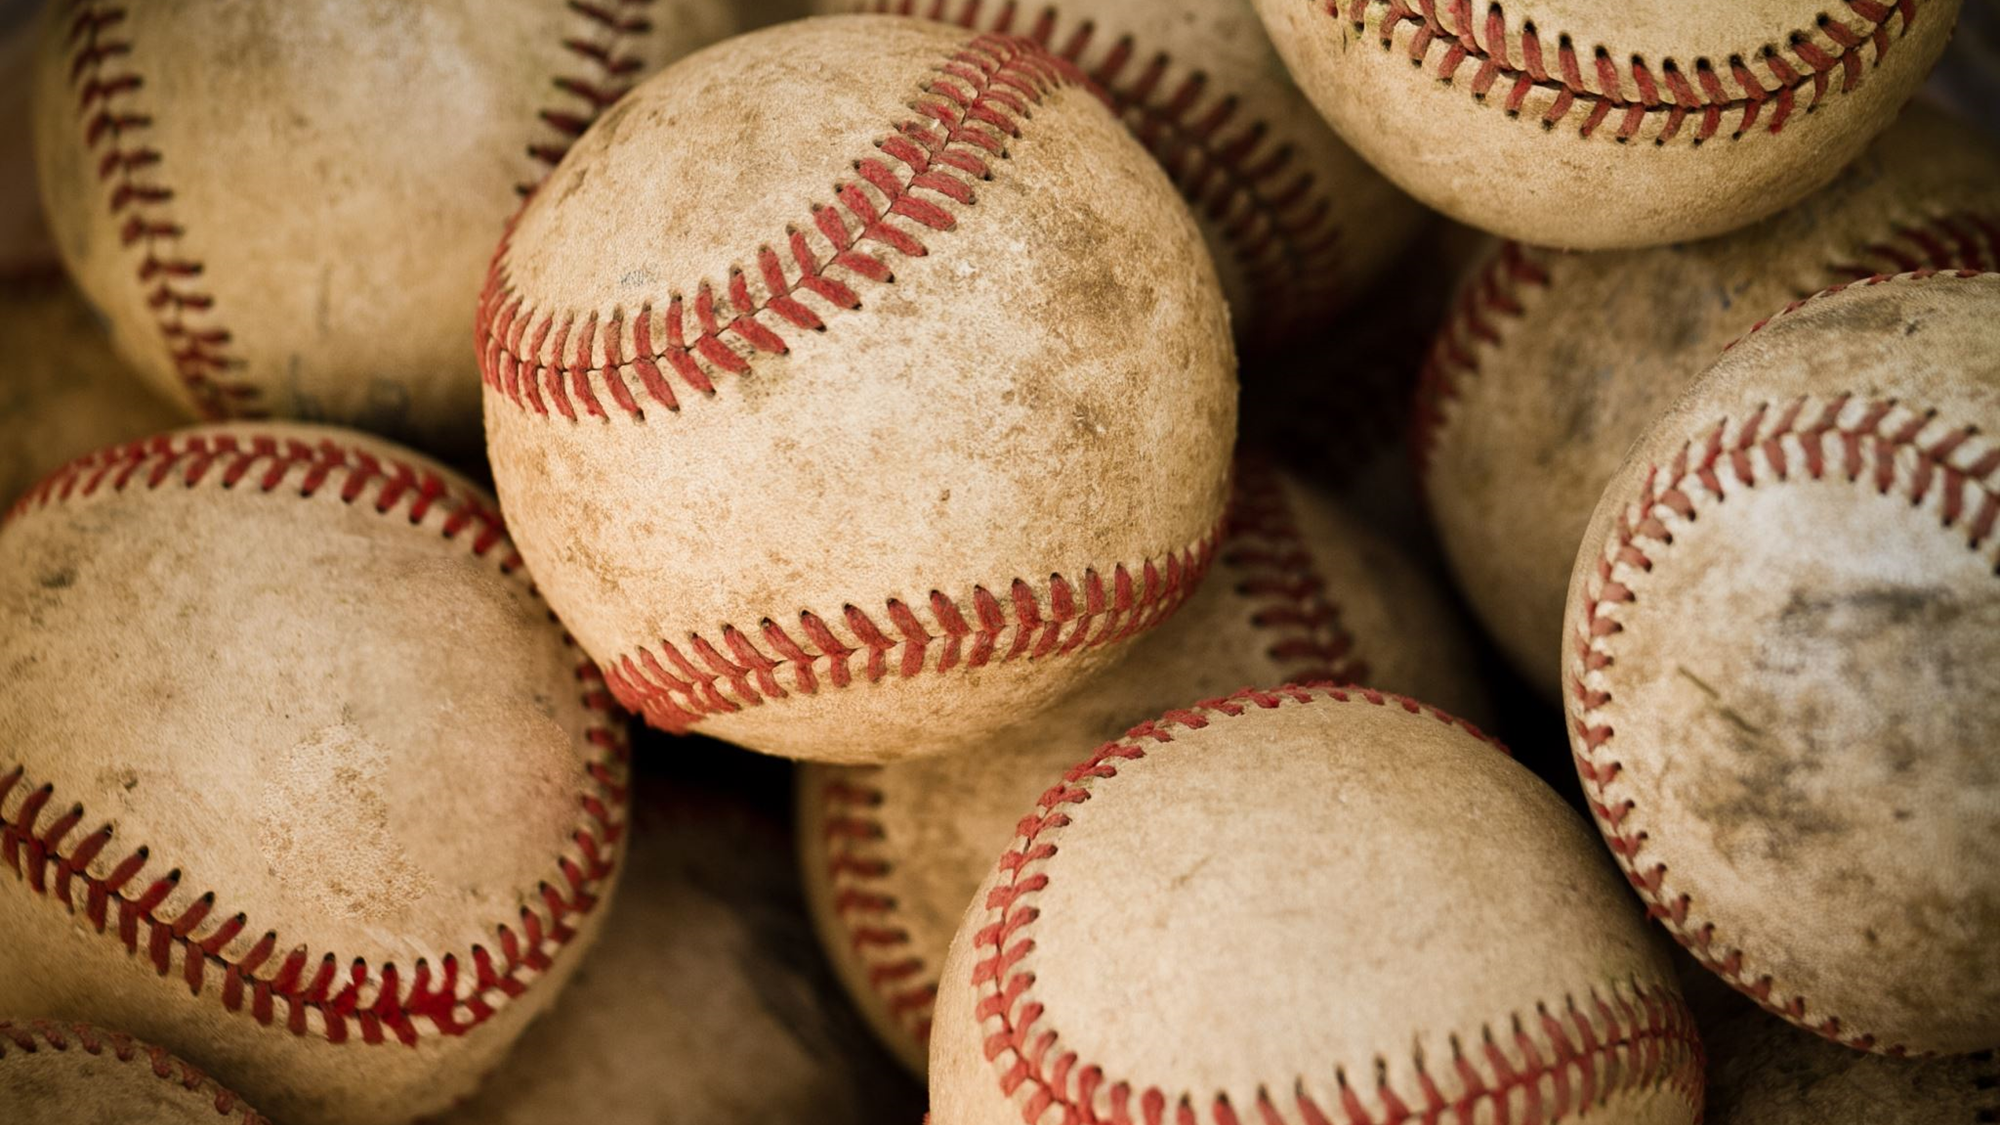

#### Overview
This project analyzes the factors associated with forecasting baseball game outcomes and provides key recommendations for success to industry leaders.

#### Business Understanding
In the highly competitive and financially driven landscape of professional baseball, accurately predicting game outcomes can significantly impact team performance, fan engagement, and revenue generation. By leveraging historical game data our predictive modeling approach aims to provide teams and stakeholders with actionable insights into future game outcomes.

#### Data and Analysis Limitations
This analysis spanned the COVID-19 pandemic. The pandemic introduced unique challenges for analyzing baseball data, requiring careful consideration of context, data quality, and potential biases when interpreting and modeling data from 2020 and beyond. In 2020 there were 60 regular season games per team, less than half of the standard 162.

Baseball has one of the richest data caches in sports, offering a plethora of statistics and metrics for analysis. Nonetheless, navigating this vast sea of information poses challenges, demanding a focused approach, organization, and an understanding of big data modeling techniques to extract meaningful insights from the wealth of available data.

### Data and Analysis Preparation

In [ ]:
# Bringing in packages for EDA, pre-processing, modeling, and visualizations
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, recall_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn.functional as F

#### Create a single dataset

In [ ]:
# Each year is saved in a separate .txt file on retrosheets.org
file_paths = ["data/gl2010.txt", "data/gl2011.txt", "data/gl2012.txt", "data/gl2013.txt", "data/gl2014.txt",
              "data/gl2015.txt", "data/gl2016.txt", "data/gl2017.txt", "data/gl2018.txt", "data/gl2019.txt",
              "data/gl2020.txt", "data/gl2021.txt", "data/gl2022.txt", "data/gl2023.txt"]

In [ ]:
dfs=[]

In [ ]:
# Pulling together the individual year files 
for file_path in file_paths:
    with open(file_path, "r") as f:
        data = f.readlines()
        data_split = [line.strip().split(",") for line in data]
        df_initial = pd.DataFrame(data_split)
        dfs.append(df_initial)

In [ ]:
# Concatenate all DataFrames in the list
df = pd.concat(dfs, ignore_index=True)

In [ ]:
df.to_csv('data/DF.csv')

### General Data Understanding
This section does a high level over view of the data. It looks at the initial head, tail, shape, description, missing values, data types, and counts. 

In [ ]:
# Setting up display 
# Set the display width to accommodate more characters per row
pd.set_option('display.width', 1000)  # Adjust as needed

# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Display the head of the DataFrame
df.info()

In [ ]:
df.head()

In [ ]:
#df.tail()

In [ ]:
#df.describe()

In [ ]:
#df.shape

In [ ]:
#nan_values = df.isna().any()
#nan_values

In [ ]:
#df.dtypes

In [ ]:
#df.count()

### Feature preparation and data manipulation 
This section renames columns, drops rows with missing column values of interest, drops columns, converts objects to numeric columns, and strips characters from object columns.    

In [ ]:
# Dropping the columns with minimalinformation at the END of the dataset
# Dropping and individual player, manager, and umpire information; this analysis will focus on overall game features
df.drop(columns=df.columns[77:179], inplace=True)

In [ ]:
# Renaming the numeric columns to something more descriptive
new_column_names = {
    0: 'date',
    1: 'num_games',
    2: 'day_of_week',
    3: 'team_visiting',
    4: 'league_visiting',
    5: 'game_num_visiting',
    6: 'team_home',
    7: 'league_home',
    8: 'game_num_home',
    9: 'score_visiting',
    10: 'score_home',
    11: 'outs_in_game',
    12: 'time_of_day',
    13: 'game_completed',
    14: 'forfeit',
    15: 'protest',
    16: 'park_id',
    17: 'attendance',
    18: 'length_min',
    19: 'line_score_visiting',
    20: 'line_score_home',   
    
    # Offense - Visiting
    21: 'at_bats_visiting',
    22: 'hits_visiting',
    23: 'double_visiting',
    24: 'triple_visiting',
    25: 'home_run_visiting',
    26: 'rbi_visiting',
    27: 'sacrifice_hit_visiting',
    28: 'sacrifice_fly_visiting',
    29: 'hit_by_pitch_visiting',
    30: 'walk_visiting',
    31: 'intent_walk_visiting',
    32: 'strikeout_visiting',
    33: 'stolen_base_visiting',
    34: 'caught_stealing_visiting',
    35: 'grounded_into_double_plays_visiting',
    36: 'first_catcher_interfere_visiting',
    37: 'left_on_base_visiting',
    
    # Pitching - Visiting
    38: 'pitchers_used_visiting',
    39: 'individual_earned_runs_visiting',
    40: 'team_earned_runs_visiting',
    41: 'wild_pitches_visiting',
    42: 'balks_visiting',
    
    # Defense - Visiting
    43: 'putouts_visiting',   
    44: 'assists_visiting',
    45: 'errors_visiting',
    46: 'passed_balls_visiting',
    47: 'double_def_visiting',
    48: 'triple_def_visiting',   
    
    # Offense - Home
    49: 'at_bats_home',
    50: 'hits_home',
    51: 'double_home',
    52: 'triple_home',
    53: 'home_run_home',
    54: 'rbi_home',
    55: 'sacrifice_hit_home',
    56: 'sacrifice_fly_home',
    57: 'hit_by_pitch_home',
    58: 'walk_home',
    59: 'intent_walk_home',
    60: 'strikeout_home',
    61: 'stolen_base_home',
    62: 'caught_stealing_home',
    63: 'grounded_into_double_plays_home',
    64: 'first_catcher_interfere_home',
    65: 'left_on_base_home',
    
    # Pitching - Home
    66: 'pitchers_used_home',
    67: 'individual_earned_runs_home',
    68: 'team_earned_runs_home',
    69: 'wild_pitches_home',
    70: 'balks_home',
    
    # Defense - Home
    71: 'putouts_home',
    72: 'assists_home',
    73: 'errors_home',
    74: 'passed_balls_home',
    75: 'double_def_home',
    76: 'triple_def_home',    
}

# Rename columns
df.rename(columns=new_column_names, inplace=True)

In [ ]:
# Removing quotations around strings--
columns_to_convert_strings = [
  'num_games',    
  'date',
  'day_of_week',
  'team_visiting',
  'league_visiting',
  'team_home',
  'league_home',   
  'time_of_day',
  'park_id',    
  'line_score_visiting',
  'line_score_home'] 

In [ ]:
df[columns_to_convert_strings] = df[columns_to_convert_strings].applymap(lambda x: x.strip('""') if isinstance(x, str) else x)

In [ ]:
# Converting most numeric columns from strings to integers
columns_to_convert = [
    "num_games", 
    "game_num_visiting", 
    "game_num_home", 
    "score_visiting", 
    'game_num_home', 
    'score_visiting',    
    'score_home', 
    "outs_in_game", 
    "attendance", 
    "length_min", 
    "at_bats_visiting",                      
    "hits_visiting", 
    "double_visiting", 
    "triple_visiting", 
    "home_run_visiting", 
    "rbi_visiting", 
    "sacrifice_hit_visiting",  
    'sacrifice_fly_visiting',
    'hit_by_pitch_visiting',
    'walk_visiting',
    'intent_walk_visiting',
    'strikeout_visiting',
    'stolen_base_visiting',
    'caught_stealing_visiting',
    'grounded_into_double_plays_visiting',
    'first_catcher_interfere_visiting',
    'left_on_base_visiting',
    'pitchers_used_visiting',
    'individual_earned_runs_visiting',
    'team_earned_runs_visiting',
    'wild_pitches_visiting',
    'balks_visiting',
    'putouts_visiting',   
    'assists_visiting',
    'errors_visiting',
    'passed_balls_visiting',
    'double_def_visiting',
    'triple_def_visiting',       
    'at_bats_home',
    'hits_home',
    'double_home',
    'triple_home',
    'home_run_home',
    'rbi_home',
    'sacrifice_hit_home',
    'sacrifice_fly_home',
    'hit_by_pitch_home',
    'walk_home',
    'intent_walk_home',
    'strikeout_home',
    'stolen_base_home',
    'caught_stealing_home',
    'grounded_into_double_plays_home',
    'first_catcher_interfere_home',
    'left_on_base_home',
    'pitchers_used_home',
    'individual_earned_runs_home',
    'team_earned_runs_home',
    'wild_pitches_home',
    'balks_home',
    'putouts_home',
    'assists_home',
    'errors_home',
    'passed_balls_home',
    'double_def_home',
    'triple_def_home']


In [ ]:
# Convert columns to numeric, coercing errors to NaN
for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')


In [ ]:
# Dropping rows with missing values in the listed columns
# at_bats_visiting - 5 rows with missing data
# double_visiting - 38 rows with missing data
# triple_visiting - 38 rows with missing data
# A total of 38 rows will be deleted; there are 43 duplicates in the 81 rows identified  
df.dropna(subset=["at_bats_visiting", "double_visiting", "triple_visiting"], inplace=True)

In [ ]:
# Drop the one row where the game ended in a tie; found this obs because when calculated run differential there was one obs with a 0 differential
df.drop(index=16957, inplace=True)

In [ ]:
# Drop rows where there was a protest
# A total of 11 rows will be deleted
df.dropna(subset=['protest'], inplace=True)
df = df[(df['protest'] != '"V"') & (df['protest'] != '"H"')]

In [ ]:
# This drops the partial 2020 season; not sure I want to drop it. It was an odd year, 
# but unless I'm looking at year as a factor what is the impact of keeping it in?
# df = df[df['year'] != 2020]

In [ ]:
df.drop(columns=["attendance", "num_games", "length_min", "game_completed", "forfeit", "protest", "day_of_week", "league_visiting", "league_home", "park_id", "time_of_day", "game_num_visiting", "game_num_home", "line_score_visiting", "line_score_home"], inplace=True)

In [ ]:
# FLO/MIA is the only team that switched three letter codes during this time period. Combining them as MIA
df['team_visiting'].replace({"FLO": "MIA"}, inplace=True)
df['team_home'].replace({"FLO": "MIA"}, inplace=True)

### Create new features
This section creates several new features: year, winning team, losing team, run differential, total runs, and on base percentage (OBP). 

In [ ]:
# Creating an integer four-digit year feature
# Extract the first four characters
year_digits = df['date'].str[0:4]

# Convert the extracted substring to numeric
df['year'] = pd.to_numeric(year_digits)
df['year'] = df['year'].astype(int)


In [ ]:
# Creating a feature for the LOSING team for each game/row
def compare_and_get_value(row):
    if row['score_visiting'] < row['score_home']:
        return row['team_visiting']
    else: 
        return row['team_home']
    
# Create a new feature based on the comparison
df['losing_team'] = df.apply(compare_and_get_value, axis=1)


In [ ]:
# Creating a feature for the WINNING team for each game/row
def compare_and_get_value(row):
    if row['score_visiting'] > row['score_home']:
        return row['team_visiting']
    else: 
        return row['team_home']
    
# Create a new feature based on the comparison
df['winning_team'] = df.apply(compare_and_get_value, axis=1)


In [ ]:
# Creating a feature for run differential for each game/row
def calculate_run_differential(row):
    if row['winning_team'] == row['team_home']:
        return row['score_home'] - row['score_visiting']
    else:
        return row['score_visiting'] - row['score_home']

# Apply the function to create a new run differential column
df['run_differential'] = df.apply(calculate_run_differential, axis=1)

In [ ]:
#df['run_differential'].value_counts()

In [ ]:
# Total Runs per Game
df['total_runs'] = df['score_home'] + df['score_visiting']
#df['total_runs'].value_counts()


In [ ]:
# OBP = (Hits + Walks + Hit by Pitch) ÷ (At Bats + Walks + Hit by Pitch + Sacrifice Flies)
df['obp_home'] = (df['hits_home'] + df['walk_home'] + df['hit_by_pitch_home']) / (df['at_bats_home'] + df['walk_home'] + df['hit_by_pitch_home'] + df['sacrifice_fly_home'])
#df['obp_home'].describe()

In [ ]:
# OBP = (Hits + Walks + Hit by Pitch) ÷ (At Bats + Walks + Hit by Pitch + Sacrifice Flies)
df['obp_visiting'] = (df['hits_visiting'] + df['walk_visiting'] + df['hit_by_pitch_visiting']) / (df['at_bats_visiting'] + df['walk_visiting'] + df['hit_by_pitch_visiting'] + df['sacrifice_fly_visiting'])
#df['obp_visiting'].describe()

### Dataframe manipulation
In this section we change the dataset from one row per game to two rows per game, one for each team for each game. Each paired row receives the same game ID to ensure pairs are kept together in the train_test_split to prevent data leakage.

In [ ]:
# Add unique numeric IDs
df['ID'] = range(1, len(df) + 1)
df['ID'] = df['ID'].astype(str) + '_w'  # Adding suffix '_w' to original IDs

# Duplicate rows and modify IDs for duplicates
duplicates = df.copy()
duplicates['ID'] = duplicates['ID'].apply(lambda x: x.replace('_w', '_l'))  # Changing suffix to '_l'

# Concatenate original DataFrame and duplicates
result = pd.concat([df, duplicates], ignore_index=True)

In [ ]:
result['win'] = result['ID'].apply(lambda x: 1 if x.endswith('_w') else 0)

In [ ]:
#result.info()

In [ ]:
result_sorted = result.sort_values(by='ID')
result_sorted.head(6)

In [ ]:
# Since I divided the winning team and losing team from each row and stacked them on top of one another we now have 64868 observations.
# Create four new DataFrames: 
# (1) Home team wins
# (2) Visiting team wins
# (3) Home team loses
# (4) Visiting team loses

home_win_df = result[(result['win'] == 1) & (result['winning_team'] == result['team_home'])].copy()
visiting_win_df = result[(result['win'] == 1) & (result['winning_team'] == result['team_visiting'])].copy()
home_lose_df = result[(result['win'] == 0) & (result['losing_team'] == result['team_home'])].copy()
visiting_lose_df = result[(result['win'] == 0) & (result['losing_team'] == result['team_visiting'])].copy()

In [ ]:
team_home_df = pd.concat([home_win_df, home_lose_df], ignore_index=True)

In [ ]:
team_visiting_df = pd.concat([visiting_win_df, visiting_lose_df], ignore_index=True)

In [ ]:
# When I stacked the dataframes on top of one another they all had to have the same feature names. 
# The _home and _visiting were removed from the features.

team_home_df.drop(columns=["at_bats_visiting", "hits_visiting", "double_visiting", "triple_visiting", "home_run_visiting", "rbi_visiting", 
            "sacrifice_hit_visiting", 'sacrifice_fly_visiting', 'hit_by_pitch_visiting', 'walk_visiting', 'intent_walk_visiting',
            'strikeout_visiting', 'stolen_base_visiting', 'caught_stealing_visiting', 'grounded_into_double_plays_visiting',
            'first_catcher_interfere_visiting', 'left_on_base_visiting', 'pitchers_used_visiting', 'individual_earned_runs_visiting',
            'team_earned_runs_visiting', 'wild_pitches_visiting', 'balks_visiting', 'putouts_visiting', 'assists_visiting',
            'errors_visiting', 'passed_balls_visiting', 'double_def_visiting', 'triple_def_visiting', 'obp_visiting','total_runs'], inplace=True)

team_visiting_df.drop(columns=["at_bats_home", "hits_home", "double_home", "triple_home", "home_run_home", "rbi_home", 
            "sacrifice_hit_home", 'sacrifice_fly_home', 'hit_by_pitch_home', 'walk_home', 'intent_walk_home',
            'strikeout_home', 'stolen_base_home', 'caught_stealing_home', 'grounded_into_double_plays_home',
            'first_catcher_interfere_home', 'left_on_base_home', 'pitchers_used_home', 'individual_earned_runs_home',
            'team_earned_runs_home', 'wild_pitches_home', 'balks_home', 'putouts_home', 'assists_home',
            'errors_home', 'passed_balls_home', 'double_def_home', 'triple_def_home', 'obp_home', 'total_runs'], inplace=True)

In [ ]:
rename_dict_home = {
   
            'at_bats_home': 'at_bats',
            'hits_home': 'hits',
            'double_home': 'double',
            'triple_home': 'triple',
            'home_run_home': 'home_run',
            'rbi_home': 'rbi',
            'sacrifice_hit_home': 'sacrifice_hit',
            'sacrifice_fly_home': 'sacrifice_fly',
            'hit_by_pitch_home': 'hit_by_pitch',
            'walk_home': 'walk',
            'intent_walk_home': 'intent_walk',
            'strikeout_home': "strikeout",
            'stolen_base_home': 'stolen_base',
            'caught_stealing_home': 'caught_stealing',
            'grounded_into_double_plays_home': 'grounded_into_double_plays',
            'first_catcher_interfere_home': 'first_catcher_interfere',
            'left_on_base_home': 'left_on_base',
            'pitchers_used_home': 'pitchers_used',
            'individual_earned_runs_home': 'individual_earned_runs',
            'team_earned_runs_home': 'team_earned_runs',
            'wild_pitches_home': 'wild_pitches',
            'balks_home': 'balks',
            'putouts_home': 'putouts',
            'assists_home': 'assists',
            'errors_home': 'errors',
            'passed_balls_home': 'passed_balls',
            'double_def_home': 'double_def',
            'triple_def_home': 'triple_def',
            'obp_home': 'obp'
}

# Rename the columns using the rename() function
team_home_df.rename(columns=rename_dict_home, inplace=True)

In [ ]:
rename_dict_visiting = {
   
            "at_bats_visiting": "at_bats",                      
            "hits_visiting": "hits", 
            "double_visiting": "double", 
            "triple_visiting": "triple", 
            "home_run_visiting": "home_run", 
            "rbi_visiting": "rbi", 
            "sacrifice_hit_visiting": "sacrifice_hit",  
            'sacrifice_fly_visiting': "sacrifice_fly",
            'hit_by_pitch_visiting': "hit_by_pitch",
            'walk_visiting': 'walk',
            'intent_walk_visiting': 'intent_walk',
            'strikeout_visiting': 'strikeout',
            'stolen_base_visiting': 'stolen_base',
            'caught_stealing_visiting': 'caught_stealing',
            'grounded_into_double_plays_visiting': 'grounded_into_double_plays',
            'first_catcher_interfere_visiting': 'first_catcher_interfere',
            'left_on_base_visiting': 'left_on_base',
            'pitchers_used_visiting': "pitchers_used",
            'individual_earned_runs_visiting': "individual_earned_runs",
            'team_earned_runs_visiting': 'team_earned_runs',
            'wild_pitches_visiting': 'wild_pitches',
            'balks_visiting': 'balks',
            'putouts_visiting': 'putouts',   
            'assists_visiting': 'assists',
            'errors_visiting': 'errors',
            'passed_balls_visiting': 'passed_balls',
            'double_def_visiting': 'double_def',
            'triple_def_visiting': 'triple_def',
            'obp_visiting': 'obp'
}

# Rename the columns using the rename() function
team_visiting_df.rename(columns=rename_dict_visiting, inplace=True)

In [ ]:
combo_df = pd.concat([team_home_df, team_visiting_df], ignore_index=True)

In [ ]:
# this is so that when I train test split I can do an exact match on ID to ensure the two teams per game end up together and prevent data leakeage
combo_df['ID'] = combo_df['ID'].str[:-2]

In [ ]:
#combo_df.info()

In [ ]:
combo_df.head()

In [ ]:
combo_df.to_csv('data/combo_df.csv')

### Exploratory Data Analysis
This section runs through a set of features looking at counts, descriptive statistics, crosstabs, and histograms.

In [ ]:
'''
# This function runs through a list of features of interest and provides the value counts of each feature.
def get_value_counts(combo_df, features):
    value_counts = {}
    for feature in features:
        value_counts[feature] = combo_df[feature].value_counts()
    return value_counts

# List of features to get value counts for
features_to_check = ['at_bats',
   'hits',
   'double',
   'triple',
   'home_run',
   'sacrifice_hit',
   'sacrifice_fly',
   'hit_by_pitch',
   'walk',
   'intent_walk',
   'strikeout',
   'stolen_base',
   'caught_stealing',
   'grounded_into_double_plays',
   'first_catcher_interfere',
   'left_on_base',
   'pitchers_used',
   'wild_pitches',
   'balks',
   'assists',
   'errors',
   'passed_balls',
   'double_def',
   'triple_def' 
      ]

# Get the value counts
value_counts = get_value_counts(combo_df, features_to_check)

# Print the value counts
for feature, counts in value_counts.items():
    print(f"\nValue counts for '{feature}':")
    print(counts)
'''    

In [ ]:
'''
# This function runs through a list of features of interest and provides the descriptive statistics for each feature.
def get_descriptive_statistics(df, features):
    descriptive_stats = {}
    for feature in features:
        descriptive_stats[feature] = df[feature].describe()
    return descriptive_stats

# List of features to get descriptive statistics for
features_to_check = ['at_bats',
   'hits',
   'double',
   'triple',
   'home_run',
   'sacrifice_hit',
   'sacrifice_fly',
   'hit_by_pitch',
   'walk',
   'intent_walk',
   'strikeout',
   'stolen_base',
   'caught_stealing',
   'grounded_into_double_plays',
   'first_catcher_interfere',
   'left_on_base',
   'pitchers_used',
   'wild_pitches',
   'balks',
   'assists',
   'errors',
   'passed_balls',
   'double_def',
   'triple_def',
    'obp']

# Get the descriptive statistics
descriptive_stats = get_descriptive_statistics(combo_df, features_to_check)

# Print the descriptive statistics
for feature, stats in descriptive_stats.items():
    print(f"\nDescriptive statistics for '{feature}':")
    print(stats)
'''

In [ ]:
#combo_df['run_differential'].describe()

In [ ]:
#combo_df['obp'].describe()

In [ ]:
#combo_df['at_bats'].describe()

In [ ]:
#combo_df['walk'].describe()

In [ ]:
#combo_df['left_on_base'].describe()

In [ ]:
#combo_df['home_run'].describe()

In [ ]:
#combo_df['pitchers_used'].describe()

In [ ]:
#combo_df['double'].describe()

In [ ]:
#combo_df['strikeout'].describe()

In [ ]:
#combo_df['intent_walk'].describe()

In [ ]:
#cross_tab = pd.crosstab(combo_df['run_differential'], combo_df['year'])
#print(cross_tab)

In [ ]:
#cross_tab2 = pd.crosstab(combo_df['strikeout'], combo_df['year'])
#print(cross_tab2)

In [ ]:
mean_obp = combo_df.groupby('win')['obp'].mean().reset_index()
median_obp = combo_df.groupby('win')['obp'].median().reset_index()
print(f"\nMean {mean_obp}")
print(f"\nMedian {median_obp}")

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: 
sns.histplot(combo_df['run_differential'], bins=26, ax=axes[0])
axes[0].set_title('Run Differential Distribution')

# Plot 2: 
sns.histplot(combo_df['obp'], bins=23, ax=axes[1])
axes[1].set_title('On Base Percentage Distribution')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: 
sns.histplot(combo_df['at_bats'], bins=36, ax=axes[0])
axes[0].set_title('At Bats Distribution')

# Plot 2: 
sns.histplot(combo_df['hits'], bins=23, ax=axes[1])
axes[1].set_title('Hits Distribution')

# Plot 3: 
sns.histplot(combo_df['strikeout'], bins=18, ax=axes[2])
axes[2].set_title('Strikeouts Distribution')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
#NOTE: 0 is included in these figures
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: 
sns.histplot(combo_df['double'], bins=8, ax=axes[0])
axes[0].set_title('Doubles Distribution')

# Plot 2: 
sns.histplot(combo_df['triple'], bins=8, ax=axes[1])
axes[1].set_title('Triples Distribution')

# Plot 3: 
sns.histplot(combo_df['home_run'], bins=8, ax=axes[2])
axes[2].set_title('Home Runs Distribution')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
#NOTE: 0 is included in these figures
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: 
sns.histplot(combo_df['sacrifice_hit'], bins=6, ax=axes[0])
axes[0].set_title('Sacrifice Hit Distribution')

# Plot 2: 
sns.histplot(combo_df['sacrifice_fly'], bins=6, ax=axes[1])
axes[1].set_title('Sacrifice Fly Distribution')

# Plot 3: 
sns.histplot(combo_df['left_on_base'], bins=6, ax=axes[2])
axes[2].set_title('Left on Base Distribution')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
#NOTE: 0 is included in these figures
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# Plot 1:
sns.histplot(combo_df['hit_by_pitch'], bins=6, ax=axes[0])
axes[0].set_title('Hit By Pitch Distribution')

# Plot 2: 
sns.histplot(combo_df['walk'], bins=22, ax=axes[1])
axes[1].set_title('Walk Distribution')

# Plot 3: 
sns.histplot(combo_df['intent_walk'], bins=6, ax=axes[2])
axes[2].set_title('Intentional Walk Distribution')

# Plot 4: 
sns.histplot(combo_df['stolen_base'], bins=6, ax=axes[3])
axes[3].set_title('Stolen Base Distribution')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
#NOTE: 0 is included in these figures
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: 
sns.histplot(combo_df['stolen_base'], bins=8, ax=axes[0])
axes[0].set_title('Stolen Base Distribution')

# Plot 2: 
sns.histplot(combo_df['caught_stealing'], bins=4, ax=axes[1])
axes[1].set_title('Caught Stealing Distribution')

# Plot 3:
sns.histplot(combo_df['double_def'], bins=8, ax=axes[2])
axes[2].set_title('Double Play Distribution')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
#NOTE: 0 is included in the Wild Pitches figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: 
sns.histplot(combo_df['pitchers_used'], bins=8, ax=axes[0])
axes[0].set_title('Pitchers Used Distribution')

# Plot 2: 
sns.histplot(combo_df['wild_pitches'], bins=8, ax=axes[1])
axes[1].set_title('Wild Pitches Distribution')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: 
sns.histplot(combo_df['errors'], bins=8, ax=axes[0])
axes[0].set_title('Errors Distribution')

# Plot 2: 
sns.histplot(combo_df['assists'], bins=24, ax=axes[1])
axes[1].set_title('Assists Distribution')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: 
sns.countplot(x='at_bats', hue='win', data=combo_df, ax=axes[0])
axes[0].set_title('At Bats Distribution by Win-Loss')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['Loss', 'Win'])

ticks = axes[0].get_xticks()  
axes[0].set_xticks(ticks[::5]) 

# Plot 2: 
sns.countplot(x='hits', hue='win', data=combo_df, ax=axes[1])
axes[1].set_title('Hits Distribution by Win-Loss')
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, ['Loss', 'Win'])

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: 
sns.countplot(x='errors', hue='win', data=combo_df, ax=axes[0])
axes[0].set_title('Error Distribution by Win-Loss')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['Loss', 'Win'])

# Plot 2: 
sns.countplot(x='walk', hue='win', data=combo_df, ax=axes[1])
axes[1].set_title('Walks Distribution by Win-Loss')
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, ['Loss', 'Win'])

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: 
sns.countplot(x='pitchers_used', hue='win', data=combo_df, ax=axes[0])
axes[0].set_title('Pitchers Used Distribution by Win-Loss')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['Loss', 'Win'])

# Plot 2: 
sns.countplot(x='home_run', hue='win', data=combo_df, ax=axes[1])
axes[1].set_title('Home Runs Distribution by Win-Loss')
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(handles, ['Loss', 'Win'])

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
combo_df['win'] = combo_df['win'].map({0: 'Lose', 1: 'Win'})
sns.barplot(x='win', y='rbi', data=combo_df, palette='Blues')

# Add labels and title
plt.xlabel('')
plt.ylabel('RBI')
plt.title('Mean RBI by Win-Loss')

# Show plot
plt.show()

In [ ]:
ax=sns.barplot(x='win', y='at_bats', data=combo_df, ci=None, palette="Blues")

# Add labels and title
plt.xlabel('')
plt.ylabel('At Bats')
plt.title('')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', 
                fontsize=12, color='black')
    
ax.set_ylim(0, 40)

# Show plot
plt.show()

In [ ]:
sns.barplot(x='win', y='strikeout', data=combo_df, ci=None, palette='Blues')

# Add labels and title
plt.xlabel('')
plt.ylabel('Strikeouts')
plt.title('Mean Strikeouts by Win-Loss')

# Show plot
plt.show()

In [ ]:
ax=sns.barplot(x='win', y='walk', data=combo_df, ci=None, palette='Blues')

# Add labels and title
plt.xlabel('')
plt.ylabel('Walks')
plt.title('')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', 
                fontsize=12, color='black')
    
ax.set_ylim(0, 4)

# Show plot
plt.show()

In [ ]:
sns.barplot(x='win', y='errors', data=combo_df, ci=None, palette='Blues')

# Add labels and title
plt.xlabel('')
plt.ylabel('Errors')
plt.title('Mean Errors by Win-Loss')

# Show plot
plt.show()

In [ ]:
sns.barplot(x='win', y='home_run', data=combo_df, ci=None, palette='Blues')

# Add labels and title
plt.xlabel('')
plt.ylabel('Home Runs')
plt.title('Mean Home Runs by Win-Loss')
                    
# Show plot
plt.show()

In [ ]:
ax=sns.barplot(x='win', y='obp', data=combo_df, ci=None, palette='Blues')

# Add labels and title
plt.xlabel('')
plt.ylabel('OBP')
plt.title('')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', 
                fontsize=12, color='black')
    
ax.set_ylim(0, .5)

# Show plot
plt.show()

In [ ]:
sns.barplot(x='win', y='pitchers_used', data=combo_df, ci=None, palette='Blues')

# Add labels and title
plt.xlabel('')
plt.ylabel('Pitchers Used')
plt.title('Mean Pitchers Used by Win-Loss')

# Show plot
plt.show()

In [ ]:
sns.barplot(x='year', y='strikeout', data=combo_df, palette='Blues')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Strikeouts')
plt.title('Mean Strikeouts by Year')

current_ticks = plt.gca().get_xticks()
plt.xticks(ticks=current_ticks[::2])

# Show plot
plt.show()

In [ ]:
sns.barplot(x='year', y='pitchers_used', data=combo_df, palette='Blues')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Pitchers Used')
plt.title('Mean Pitchers Used by Year')

current_ticks = plt.gca().get_xticks()
plt.xticks(ticks=current_ticks[::2])

# Show plot
plt.show()

In [ ]:
sns.barplot(x='year', y='home_run', data=combo_df, palette='Blues')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Home Runs')
plt.title('Mean Home Runs by Year')

current_ticks = plt.gca().get_xticks()
plt.xticks(ticks=current_ticks[::2])

# Show plot
plt.show()

In [ ]:
sns.barplot(x='year', y='double', data=combo_df, palette='Blues')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Doubles')
plt.title('Mean Doubles by Year')

current_ticks = plt.gca().get_xticks()
plt.xticks(ticks=current_ticks[::2])

# Show plot
plt.show()

In [ ]:
# Calculate the mean 'score_home' for each 'team_home'
mean_score_home = combo_df.groupby('team_home')['score_home'].mean().reset_index()

# Sort the data by mean 'score_home'
mean_score_home_sorted = mean_score_home.sort_values(by='score_home', ascending=False)

# Calculate the mean 'score_visiting' for each 'team_visiting'
mean_score_visiting = combo_df.groupby('team_visiting')['score_visiting'].mean().reset_index()

# Sort the data by mean 'score_visiting'
mean_score_visiting_sorted = mean_score_visiting.sort_values(by='score_visiting', ascending=False)

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Bar plot of mean 'score_home' by 'team_home'
sns.barplot(x='score_home', y='team_home', data=mean_score_home_sorted, ax=axes[0], palette='Blues_r')
axes[0].set_title('Mean Score by Home Teams (2010-2023)')

# Plot 2: Bar plot of mean 'score_visiting' by 'team_visiting'
sns.barplot(x='score_visiting', y='team_visiting', data=mean_score_visiting_sorted, ax=axes[1], palette='Blues_r')
axes[1].set_title('Mean Score by Visiting Teams (2010-2023)')

# Show plot
plt.show()

FUN NOTE: Colorado on average score more runs at home than any other team and on average score the least runs compared to any other team on the road. Does the thin air really make that much of a difference? Something of interest to explore in a future analysis!

In [ ]:
combo_df['win'] = combo_df['win'].map({'Lose':0, 'Win': 1})

In [ ]:
combo_df.to_csv('data/Combo_DF.csv')

### Modeling 
Data are split into a training set and test set for modeling. Games are paired so that features for the winning team and losing team of a game are not split between the training and test set to prevent data leakage. Features are standard scale standardized. No additional preprocessing is used. There are no categorical features, no missing data, and the target is 50:50 balanced. 

The primary evaluation metric used for these models is accuracy. With a balanced dataset and equal interest in classification of wins as much as losses, accuracy is an appropriate evaluation metric.

X features varied by model and included: 'at_bats', 'hits', 'obp', 'double', 'triple', 'home_run', 'sacrifice_hit', 'sacrifice_fly', 'hit_by_pitch', 'walk', 'intent_walk', 'strikeout', 'stolen_base', 'caught_stealing', 'left_on_base', 'pitchers_used', 'wild_pitches', 'assists', 'errors', 'double_def'. 

In [ ]:
# Group by Game_ID
grouped = combo_df.groupby('ID')

# Convert groups to a list of DataFrames
game_list = [group for _, group in grouped]

# Perform train-test split on the list of games
train_games, test_games = train_test_split(game_list, test_size=0.2, random_state=13)

# Concatenate the DataFrames back into train and test sets
train_df = pd.concat(train_games).reset_index(drop=True)
test_df = pd.concat(test_games).reset_index(drop=True)

In [ ]:

# The X features were selected based on EDA and domain interest
X_train= train_df[[
   'double',
   'triple',
   'home_run',
   'sacrifice_hit',
   'sacrifice_fly',
   'hit_by_pitch',
   'walk',
   'intent_walk',
   'strikeout',
   'stolen_base',
   'caught_stealing',
   'left_on_base',
   'pitchers_used',
   'wild_pitches',
   'assists',
   'errors',
   'double_def',
   'obp',
   'hits',
   'at_bats'
   ]]

y_train= train_df['win']

X_test= test_df[[
   'double',
   'triple',
   'home_run',
   'sacrifice_hit',
   'sacrifice_fly',
   'hit_by_pitch',
   'walk',
   'intent_walk',
   'strikeout',
   'stolen_base',
   'caught_stealing',
   'left_on_base',
   'pitchers_used',
   'wild_pitches',
   'assists',
   'errors',
   'double_def',
   'obp',
   'hits',
   'at_bats'
   ]]

y_test= test_df['win']

#### Preprocessing
Data were standard scaled. X features were all numeric. There were no missing data. There was 50/50 class balance. No other preproccessors were used.

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Baseline (Dummy) Model

The first model is a Dummy Classifier. As expected using the most frequent strategy the accuracy score of this balanced data set is 50%. 

In [ ]:
# Instantiate the model using most_frequent
dummy_model = DummyClassifier(strategy="most_frequent")

# fitting the model 
dummy_model.fit(X_train_scaled, y_train)

# predicting
y_pred_dummy = dummy_model.predict(X_test_scaled)
dummy_model.score(X_train_scaled, y_train)

If the model were to predict 1 (a win) each time, it would be accurate 50% of the time. This serves as a basic baseline to use as a comparison for models.

In [ ]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

#### Decision Tree and Random Forest
The second model is a simple Decision Tree Classifier using parameters for criterion, maximum depth, and the full set of X features listed above. The accuracy score for this model is 75%. The model identifies: obp, left_on_base, intent_walk, at_bats, home_run, sacrifice_fly, and double as the seven most important features in order of importance.

Next a Random Forest Classifier uses a grid search for the estimator, and maxium depth and features. The best parameters are used in the model with the full set of X features listed above. The accuracy score for this model is 80%. The model identifies:  home_run', 'obp', 'hits', 'left_on_base', 'errors', 'intent_walk', 'at_bats' as the seven most important features.

In [ ]:
# Initialize Decision Tree
tree = DecisionTreeClassifier(random_state=13)

In [ ]:
# Train the model on the training data
tree.fit(X_train_scaled, y_train)

tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=13)
tree.fit(X_train_scaled, y_train)
y_pred = tree.predict(X_test_scaled)
precision_score(y_test, y_pred, average="weighted")

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
# Get feature importances
feature_importances = tree.feature_importances_

# Get the original feature names
feature_names = X_train.columns

# Map the indices to feature names
feature_indices = tree.tree_.feature
for idx in feature_indices:
    if idx != -2:  # -2 is a special value in the tree structure indicating no feature (leaf node)
        print(f'Feature index {idx} corresponds to feature name: {feature_names[idx]}')

# Alternatively, get the feature importance along with the feature names
importances = list(zip(feature_names, feature_importances))
importances = sorted(importances, key=lambda x: x[1], reverse=True)
print("Feature importances (sorted):")
for feature, importance in importances:
    print(f'{feature}: {importance:.4f}')

In [ ]:
# plotting the figure
plt.figure(figsize=(20,15))  # set plot size (denoted in inches)
plot_tree(tree, fontsize=11)
plt.show();

In [ ]:
# Initialize Random Forest model
rf = RandomForestClassifier(random_state=13)

In [ ]:
# Creating a grid search to find the best hyperparameters to include in the model
grid = {
    'n_estimators': [1000, 2000],
    'max_depth': [8, 10, 12],
    'max_features': [8, 10, 12]
       }

In [ ]:
grid_search = GridSearchCV(estimator=rf, param_grid=grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
# Train the model on the training data
rf.fit(X_train_scaled, y_train)

rf = RandomForestClassifier(n_estimators=2000, max_features=8, max_depth=12, random_state=13)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
# Get feature importances
feature_importances = rf.feature_importances_

# Get the original feature names
feature_names = X_train.columns

# Feature importance with feature names
importances = list(zip(feature_names, feature_importances))
importances = sorted(importances, key=lambda x: x[1], reverse=True)
print("Feature importances (sorted):")
for feature, importance in importances:
    print(f'{feature}: {importance:.4f}')

#### Logistic Regression 

Next, a logistic regression was performed to classify each game based on the predictors. Logistic Regression is a good model to use for classification. In this instance, a binary classification was performed to determine whether a game was won (1) or lost (0) for each team. The model uses the full set of X features listed above. The accuracy score for this model is 78%.

The second Logistic Regression model uses the subset of X features identified as the most important features from the Random Forest: home_run', 'obp', 'hits', 'left_on_base', 'errors', 'intent_walk', 'at_bats'. The accuracy score for this model is 76%.

#### Log Model 1

In [ ]:
# instantiating the model
logreg_full = LogisticRegression(random_state=13)

# fitting the model to our scaled training set
logreg_full.fit(X_train_scaled, y_train)


In [ ]:
# predicting our target
y_pred = logreg_full.predict(X_test_scaled)
y_pred

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

In [ ]:
plot_confusion_matrix(logreg_full, X_test_scaled, y_test);

In [ ]:
# printing out a full classification report to check precision and recall
print(classification_report(y_test, y_pred))

#### Log Model 2

In [ ]:
# The X features were selected based on the Random Forest Feature Importance

X_train_DT= train_df[[
   'home_run', 
   'obp',
   'hits',
   'left_on_base',
   'errors',
   'intent_walk',
   'at_bats'
       ]]

y_train= train_df['win']

X_test_DT= test_df[[
   'home_run', 
   'obp',
   'hits',
   'left_on_base',
   'errors',
   'intent_walk',
   'at_bats'
   ]]

y_test= test_df['win']

In [ ]:
scaler = StandardScaler()

X_train_DT_scaled = scaler.fit_transform(X_train_DT)
X_test_DT_scaled = scaler.transform(X_test_DT)

In [ ]:
# instantiating the model
logreg_DT = LogisticRegression(random_state=13)

# fitting the model to our scaled training set
logreg_DT.fit(X_train_DT_scaled, y_train)

In [ ]:
# predicting our target
y_pred = logreg_DT.predict(X_test_DT_scaled)
y_pred

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

In [ ]:
plot_confusion_matrix(logreg_DT, X_test_DT_scaled, y_test);

In [ ]:
# printing out a full classification report to check precision and recall
print(classification_report(y_test, y_pred))

In [ ]:
# printing out the coefficients
coefficients = logreg_DT.coef_
print("Coefficients:", coefficients)

In [ ]:
# converting from log-odds to probabilities using a list comprehension from this source: https://stackoverflow.com/questions/51006193/interpreting-logistic-regression-feature-coefficient-values-in-sklearn
probabilities = [np.exp(x)/(1 + np.exp(x)) for x in coefficients[0]]
probabilities

#### Neural Network

The last model is a Neural Network. This model is built using extensive support from ChatGPT. The full set of X features listed above are used in the model. The accuracy score for this model is 81%; the best performing model. The seven most important feature identified in order of importance are: at_bats, left_on_base, walk, obp, pitchers_used, hits, and strikeouts, in order of importance. 

In [ ]:
X = X_train_scaled
y = y_train.values

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(20, 50)  # Adjust input size if necessary
        self.fc2 = nn.Linear(50, 2)   # Assuming binary classification (2 output classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")

# Evaluate the model on the test set
model.eval()
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
with torch.no_grad():
    outputs = model(X_test_tensor)
    probabilities = F.softmax(outputs, dim=1)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f"Accuracy: {accuracy * 100:.2f}%")
print("Class probabilities:")
print(probabilities.numpy())

In [ ]:
# Extract feature importances from the first layer of the model
importances = model.fc1.weight.detach().numpy()

# Calculate the mean absolute importance for each feature
feature_importance = np.mean(np.abs(importances), axis=0)

# Create a list of (feature_name, importance) tuples
feature_importance_tuples = [(name, importance) for name, importance in zip(X_train.columns, feature_importance)]

# Sort the list of tuples by importance in descending order
sorted_feature_importance = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
print("Feature Importances (most to least important):")
for name, importance in sorted_feature_importance:
    print(f"{name}: {importance:.4f}")

### Findings and Recommendations
While pitching and defense are crucial for well-rounded teams, the most important factors identified by this analysis when scouting is offense. Players who can get on base, especially those with a keen eye for spotting balls over strikes and earning walks, create more opportunities for additional at-bats.